In [359]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [360]:
# get test data
df_test = pd.read_csv("../input/test.csv")

# get train data
df_train = pd.read_csv("../input/train.csv")

# get gender submission

df_gender = pd.read_csv("../input/gender_submission.csv")

In [361]:
# check df_train
df_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
474,475,0,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S
457,458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
281,282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,NaN,S
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S
666,667,0,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,NaN,S
482,483,0,3,"Rouse, Mr. Richard Henry",male,50.0,0,0,A/5 3594,8.0500,NaN,S
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
242,243,0,2,"Coleridge, Mr. Reginald Charles",male,29.0,0,0,W./C. 14263,10.5000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [362]:
# info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [363]:
# summary statistic
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [364]:
# shape
df_train.shape

(891, 12)

In [365]:
# check duplication
df_train.duplicated().sum()

0

In [366]:
# check missing value
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

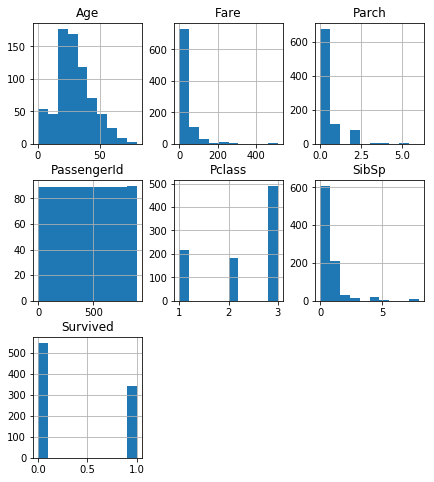

In [367]:
# hist
df_train.hist(figsize=[7,8]);

In [368]:
# survival ratio
print(df_train.Survived.mean())

0.3838383838383838


In [369]:
# check max fare as it seems outlier
df_train["Fare"].sort_values(ascending = False).head()

679    512.3292
258    512.3292
737    512.3292
341    263.0000
438    263.0000
Name: Fare, dtype: float64

In [370]:
# check from which class the outliers come
df_train[df_train["Fare"] >500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


-  I will leave the outliers as they purchased 1 class tickets which should be expensive and the price could be realistic.

# Quality issue

- passenger id is int data type
- Pclass is int data type
- sex is string
- embark is string
- missing value in Age, Embarked and especially Cabin
- cabin column contains several data

# Tidiness issue
- title is together with name


## Missing value
## Definition
> Missing age data need to be filled. Check if there any coorelation between age and some features to decide how to fill in.p

In [371]:
# copy the train df

df_train_sub = df_train.copy()

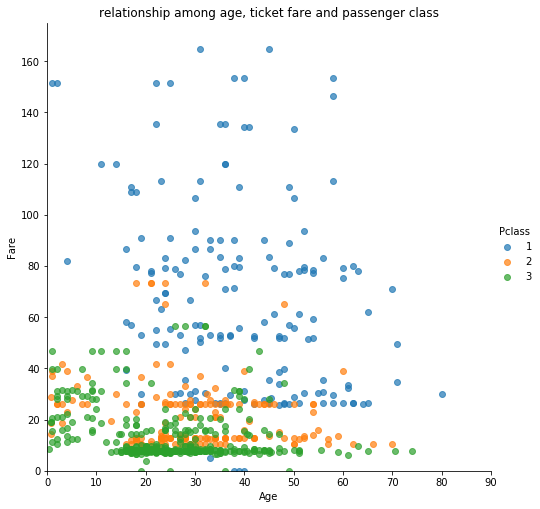

In [372]:
# plot age, fare and pclass

g = sns.FacetGrid(data = df_train_sub, hue = "Pclass", height = 7)
g.map(plt.scatter, "Age", "Fare", alpha = 0.7)
g.set(xlim =[0,90], ylim = [0, 175])
g.add_legend()
plt.title("relationship among age, ticket fare and passenger class");

In [373]:
# check how many missing age in each Pclass
df_train_sub[df_train_sub.Age.isnull()].Pclass.value_counts()

3    136
1     30
2     11
Name: Pclass, dtype: int64

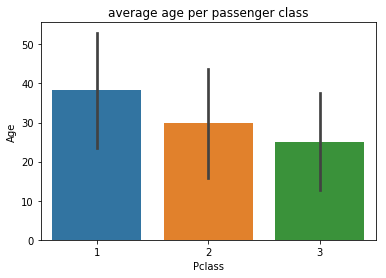

In [374]:
# visualize with a SD line
g = sns.barplot(data = df_train_sub, x = "Pclass", y = "Age", ci = "sd")
g.set_title("average age per passenger class");

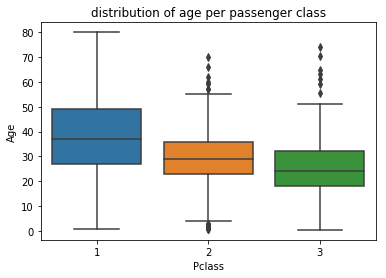

In [375]:
# check distribution
g = sns.boxplot(data = df_train_sub, x = "Pclass", y = "Age")
g.set_title("distribution of age per passenger class");

> I will take a mean of age in each Pclass and replace respectively.

In [376]:
# get mean for each Pclass
first_mean, second_mean,third_mean = df_train_sub.groupby("Pclass").Age.mean()

In [377]:
# replace na with respective mean
age_na_1 = df_train_sub[(df_train_sub["Pclass"]== 1) & (df_train_sub["Age"].isna())].index
df_train_sub.loc[age_na_1,"Age"] = first_mean

age_na_2 = df_train_sub[(df_train_sub["Pclass"]== 2) & (df_train_sub["Age"].isna())].index
df_train_sub.loc[age_na_2,"Age"] = second_mean

age_na_3 = df_train_sub[(df_train_sub["Pclass"]== 3) & (df_train_sub["Age"].isna())].index
df_train_sub.loc[age_na_3,"Age"] = third_mean


> ## Test

In [378]:
# check results
df_train_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


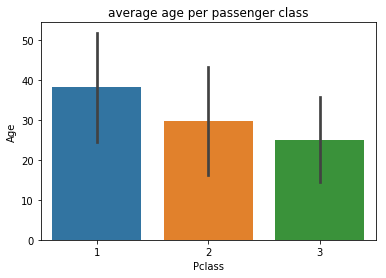

In [379]:
# visualize with a SD line again
g = sns.barplot(data = df_train_sub, x = "Pclass", y = "Age", ci = "sd")
g.set_title("average age per passenger class");

## Definition

fill in missing values in the Embarked column.
* Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [380]:
# check 
df_train_sub[df_train_sub["Embarked"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


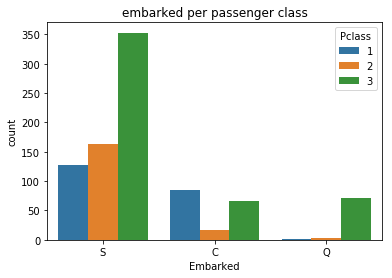

In [381]:
# check frequency
g = sns.countplot(data = df_train_sub, x = "Embarked", hue = "Pclass")
g.set_title("embarked per passenger class");

In [382]:
# replace with the most frequent one which is S
embarked_na = df_train_sub[df_train_sub["Embarked"].isna()].index
df_train_sub.loc[embarked_na, "Embarked"] = "S"

## Test

In [383]:
# check
df_train_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Definition
Cabin column is missing more than 3/4 of original data. I will check what I can do with it.

In [384]:
df_train_sub["Cabin_letter"] = df_train_sub["Cabin"].str.extract('([A-Z])')

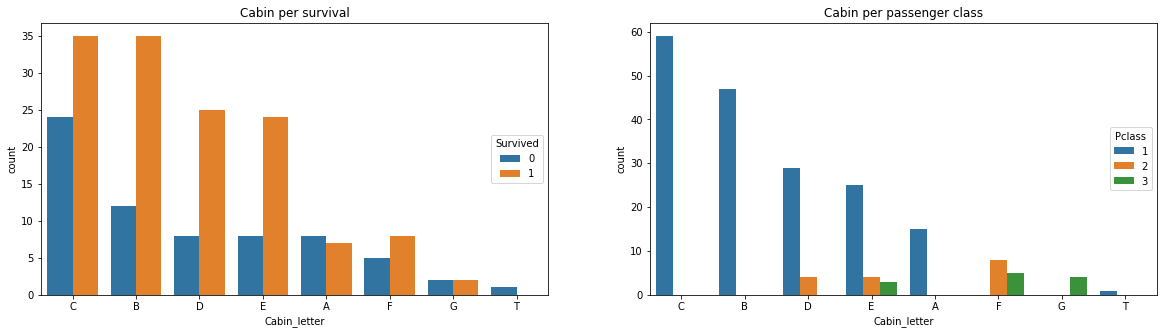

In [385]:
# plot
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
g = sns.countplot(data = df_train_sub, x = "Cabin_letter", hue = "Survived",
              order = df_train_sub['Cabin_letter'].value_counts().index)
g.set_title("Cabin per survival")
g.legend(loc="center right", title = "Survived")


plt.subplot(1,2,2)
g = sns.countplot(data = df_train_sub, x = "Cabin_letter", hue = "Pclass",
              order = df_train_sub['Cabin_letter'].value_counts().index)
g.set_title("Cabin per passenger class")
g.legend(loc="center right", title = "Pclass");

> Cabin A,B and C only show 1st class passengers. <p></p>
> Cabin T maight be an error, as there are no alphabet between G and T.<p></p>
Further more, the cabin column seems to have a meaning, so I will leave the column for now.


In [386]:
# show the passenger with T Cabin
df_train_sub[df_train_sub["Cabin_letter"] == "T"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_letter
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,T


It is very unlikely that the cabin has no number next to the alphabet like other passenger.

In [387]:
# replace cabin T to np.nan
T_index = df_train_sub[df_train_sub["Cabin_letter"] == "T"].index
df_train_sub.loc[T_index, "Cabin"] = np.nan
df_train_sub.loc[T_index, "Cabin_letter"] = np.nan

## Test

In [388]:
# check
df_train_sub.Cabin_letter.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

## Tidiness
## Definition
Name column contains a title. Separate it from the name.

In [389]:
# extract titles
df_train_sub["Title"] = df_train_sub["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()

In [390]:
# check unique titles
df_train_sub.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [391]:
# check unique titles
df_train_sub.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Sir               1
Lady              1
Don               1
Mme               1
Jonkheer          1
Ms                1
Capt              1
the Countess      1
Name: Title, dtype: int64

In [392]:
# create new column with a name without a title
df_train_sub["Full_name"] = df_train_sub["Name"].str.split(",").str[0] + df_train_sub["Name"].str.split(",").str[1].str.split(".").str[1]

In [393]:
# check
df_train_sub[["Name","Full_name", "Title"]].sample(3)

,Name,Full_name,Title
46,"Lennon, Mr. Denis",Lennon Denis,Mr
128,"Peter, Miss. Anna",Peter Anna,Miss
673,"Wilhelms, Mr. Charles",Wilhelms Charles,Mr


In [394]:
# drop Name
df_train_sub.drop("Name", axis = 1, inplace = True)

## Test

In [395]:
df_train_sub.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_letter', 'Title',
       'Full_name'],
      dtype='object')

## Quality
## Definition
Correct data types
- passenger id to string
- Pclass to categorical
- sex to categorical
- cabin_letter to categorical
- embark to categorical

In [396]:
# change data types
df_train_sub["PassengerId"] = df_train_sub["PassengerId"].astype("str")
df_train_sub["Pclass"] = df_train_sub["Pclass"].astype("category")
df_train_sub["Sex"] = df_train_sub["Sex"].astype("category")
df_train_sub["Cabin_letter"] = df_train_sub["Cabin_letter"].astype("category")
df_train_sub["Embarked"] = df_train_sub["Embarked"].astype("category")

## Test

In [397]:
# check
df_train_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId     891 non-null object
Survived        891 non-null int64
Pclass          891 non-null category
Sex             891 non-null category
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           203 non-null object
Embarked        891 non-null category
Cabin_letter    203 non-null category
Title           891 non-null object
Full_name       891 non-null object
dtypes: category(4), float64(2), int64(3), object(5)
memory usage: 73.8+ KB


In [398]:
df_train_sub.sample(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_letter,Title,Full_name
746,747,0,3,male,16.000000,1,1,C.A. 2673,20.2500,NaN,S,NaN,Mr,Abbott Rossmore Edward
779,780,1,1,female,43.000000,0,1,24160,211.3375,B3,S,B,Mrs,Robert Edward Scott (Elisabeth Walton McMillan)
684,685,0,2,male,60.000000,1,1,29750,39.0000,NaN,S,NaN,Mr,Brown Thomas William Solomon
839,840,1,1,male,38.233441,0,0,11774,29.7000,C47,C,C,Mr,Marechal Pierre
201,202,0,3,male,25.140620,8,2,CA. 2343,69.5500,NaN,S,NaN,Mr,Sage Frederick
91,92,0,3,male,20.000000,0,0,347466,7.8542,NaN,S,NaN,Mr,Andreasson Paul Edvin
99,100,0,2,male,34.000000,1,0,244367,26.0000,NaN,S,NaN,Mr,Kantor Sinai
653,654,1,3,female,25.140620,0,0,330919,7.8292,NaN,Q,NaN,Miss,"O'Leary Hanora ""Norah"""
154,155,0,3,male,25.140620,0,0,Fa 265302,7.3125,NaN,S,NaN,Mr,Olsen Ole Martin
50,51,0,3,male,7.000000,4,1,3101295,39.6875,NaN,S,NaN,Master,Panula Juha Niilo


# Exploratory data analysis

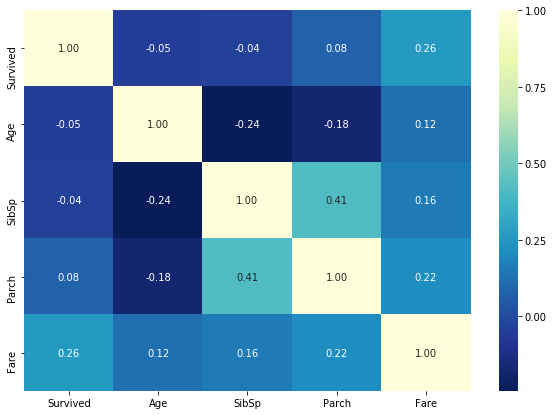

In [399]:
# heat map numerical
corr = df_train_sub.corr()

plt.figure(figsize=[10,7])
sns.heatmap(corr, annot = True, fmt = ".2f",cmap = "YlGnBu_r");

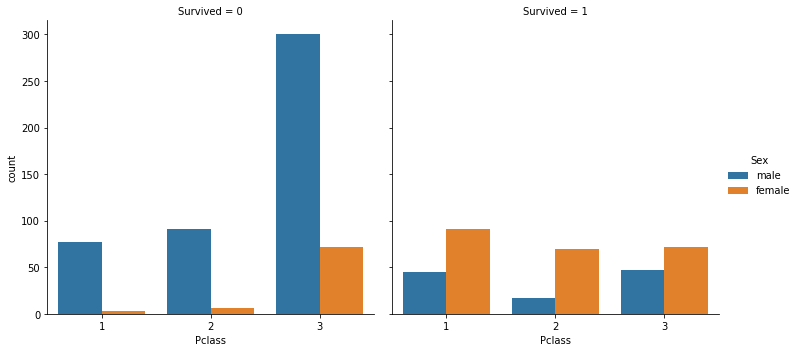

In [400]:
g = sns.catplot(data = df_train_clean, x = "Pclass",col = "Survived", kind = "count", hue = "Sex" )

female passenger were more likely to survive.

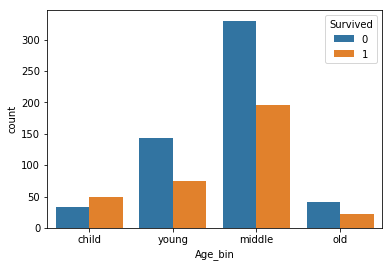

In [401]:
bin_edge = [0, 15, 25, 50, 80]
bin_name = ["child","young", "middle", "old"]
df_train_sub["Age_bin"] = pd.cut(df_train_sub["Age"],bin_edge, labels = bin_name)
sns.countplot(data = df_train_sub, x = "Age_bin", hue="Survived")


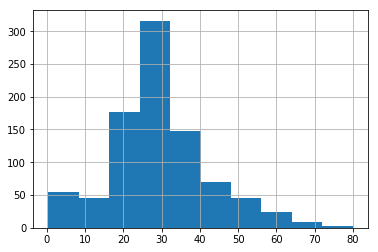

In [402]:
df_train_sub["Age"].hist()

In [403]:
df_train_sub.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.292875,0.523008,0.381594,32.204208
std,0.486592,13.210527,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,37.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


# Feature engineering

## Definition
> replace titles with group titles
- Mr. = title for men   ----> m_title
- Miss. = title for unmarried women ----> f_title
- Mrs. = title for married or widowed women ---> f_title
- Master. = honorific for boys and young men ---> special
- Dr. = academic title ---> special (at that time??)
- Rev. = The Reverend is an honorific style most often placed before the names of Christian clergy and ministers.(https://en.wikipedia.org/wiki/The_Reverend) ---> special
- Col. =  title Colonel military unit ---> military
- Major. = military rank ----> military
- Mlle. = Mademoiselle is a French familiar title, abbreviated Mlle, traditionally given to an unmarried woman. (wikipedia) ---> f_title
- Capt. = title for the commander of a military unit ---> military
- Ms. = title for unmarried or unknown status women ---> f_title
- Sir. = The title of "Sir" is given to anyone awarded knighthood by the Queen or a member of the royal family (https://www.reference.com/world-view/title-sir-given-934711913b5cc171) ---> special
- Countess. = Countess is the Title taken by the wife of an Earl or Count ---> special
- Lady. = The honorific prefix of "Lady" is used for the daughters of dukes, marquesses and earls. (wikipedia) ---> special
- Jonkheer = honorific in the Low Countries denoting the lowest rank within the nobility (wikipedia) ---> special
- Don. = an honorific prefix primarly used in Italy, Spain, Portugal, Latin America, and the Philippines. (wikipedia) ---> special
- Mme. = Madam in French ---> f_title
> male_title, female_itle, military_title and special_title??

In [404]:
# replace titles
df_train_sub["Title"].replace(["Mr"], "m_title", inplace = True)
df_train_sub["Title"].replace(["Miss", "Mrs", "Mlle", "Mme", "Ms"], "f_title", inplace = True)
df_train_sub["Title"].replace(["Col", "Major", "Capt"], "military_title", inplace = True)
df_train_sub["Title"].replace(["Master", "Dr", "Rev", "Sir", "the Countess",
                                 "Lady", "Jonkheer", "Don"], "special_title", inplace = True)

## Test

In [405]:
# check
df_train_sub.Title.unique()

array(['m_title', 'f_title', 'special_title', 'military_title'],
      dtype=object)